#### Processing Data of Beat AML data wave 1/2
#### Data were downloaded from the orginal paper (doi: 10.1038/s41586-018-0623-z)

In [10]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src/')
import matrix_convert as mc

# Loading BeatAML wave1/2 dataset

In [11]:
Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
BeatAML_mut = pd.read_csv(Data_dir +"Mutation.csv")
BeatAML_drug_response = pd.read_csv(Data_dir + "Drug_Response.csv")
print(np.median(BeatAML_drug_response.loc[BeatAML_drug_response['inhibitor'] == 'Venetoclax']['ic50']))
# The median value for Venetoclax IC50 is 1.45 uM.
BeatAML_rnaseq = pd.read_csv(Data_dir + "RPKM.csv")

1.45261900330956


# Select high frequently mutated genes 


In [12]:
BeatAML_mut_s = BeatAML_mut.loc[:,['labId','chosen_consequence', 'impact', 'symbol','amino_acids','genotyper']]

#select variants from BeatAML_mut_s if the genotyper includes both mutect and varsan
BeatAML_mut_s['new_id'] = BeatAML_mut_s['symbol'] +':'+ BeatAML_mut_s['amino_acids']

print("The number of unique mutations in BeatAML_mut_s identified by either mutect or varscan: ")
print(len(BeatAML_mut_s['new_id'].unique()))
print("The number of unique mutations in BeatAML_mut_s identified by mutect: ")
print(len(BeatAML_mut_s.loc[BeatAML_mut_s['genotyper'] == 'mutect']['new_id'].unique()))
print("The number of unique mutations in BeatAML_mut_s identified by varscan: ")
print(len(BeatAML_mut_s.loc[BeatAML_mut_s['genotyper'] == 'varscan']['new_id'].unique()))
print("The number of unique mutations in BeatAML_mut_s identified by both mutect and varscan: ")
print(len(set(BeatAML_mut_s.loc[BeatAML_mut_s['genotyper'] == 'mutect']['new_id'].unique()).intersection(BeatAML_mut_s.loc[BeatAML_mut_s['genotyper'] == 'varscan']['new_id'].unique())))

The number of unique mutations in BeatAML_mut_s identified by either mutect or varscan: 
4522
The number of unique mutations in BeatAML_mut_s identified by mutect: 
3409
The number of unique mutations in BeatAML_mut_s identified by varscan: 
3583
The number of unique mutations in BeatAML_mut_s identified by both mutect and varscan: 
2538


In [13]:
# Convert gene mutation to a matrix
BeatAML_mut_matrix = mc.convert_df2matrix_bi(BeatAML_mut,"labId","symbol")

# Select highly frequent mutated genes
selected_genes = []
for gene in BeatAML_mut_matrix.columns:
    if BeatAML_mut_matrix.loc[BeatAML_mut_matrix[gene] == 1].shape[0] >= 0.03*BeatAML_mut_matrix.shape[0]:
        selected_genes.append(gene)

selected_mutation_matrix = BeatAML_mut_matrix[selected_genes]
# Save the selected mutation matrix
print(selected_mutation_matrix.shape )
selected_mutation_matrix.to_csv("../data/Feature_set1_mutation_matrix_w12.csv")

(608, 22)


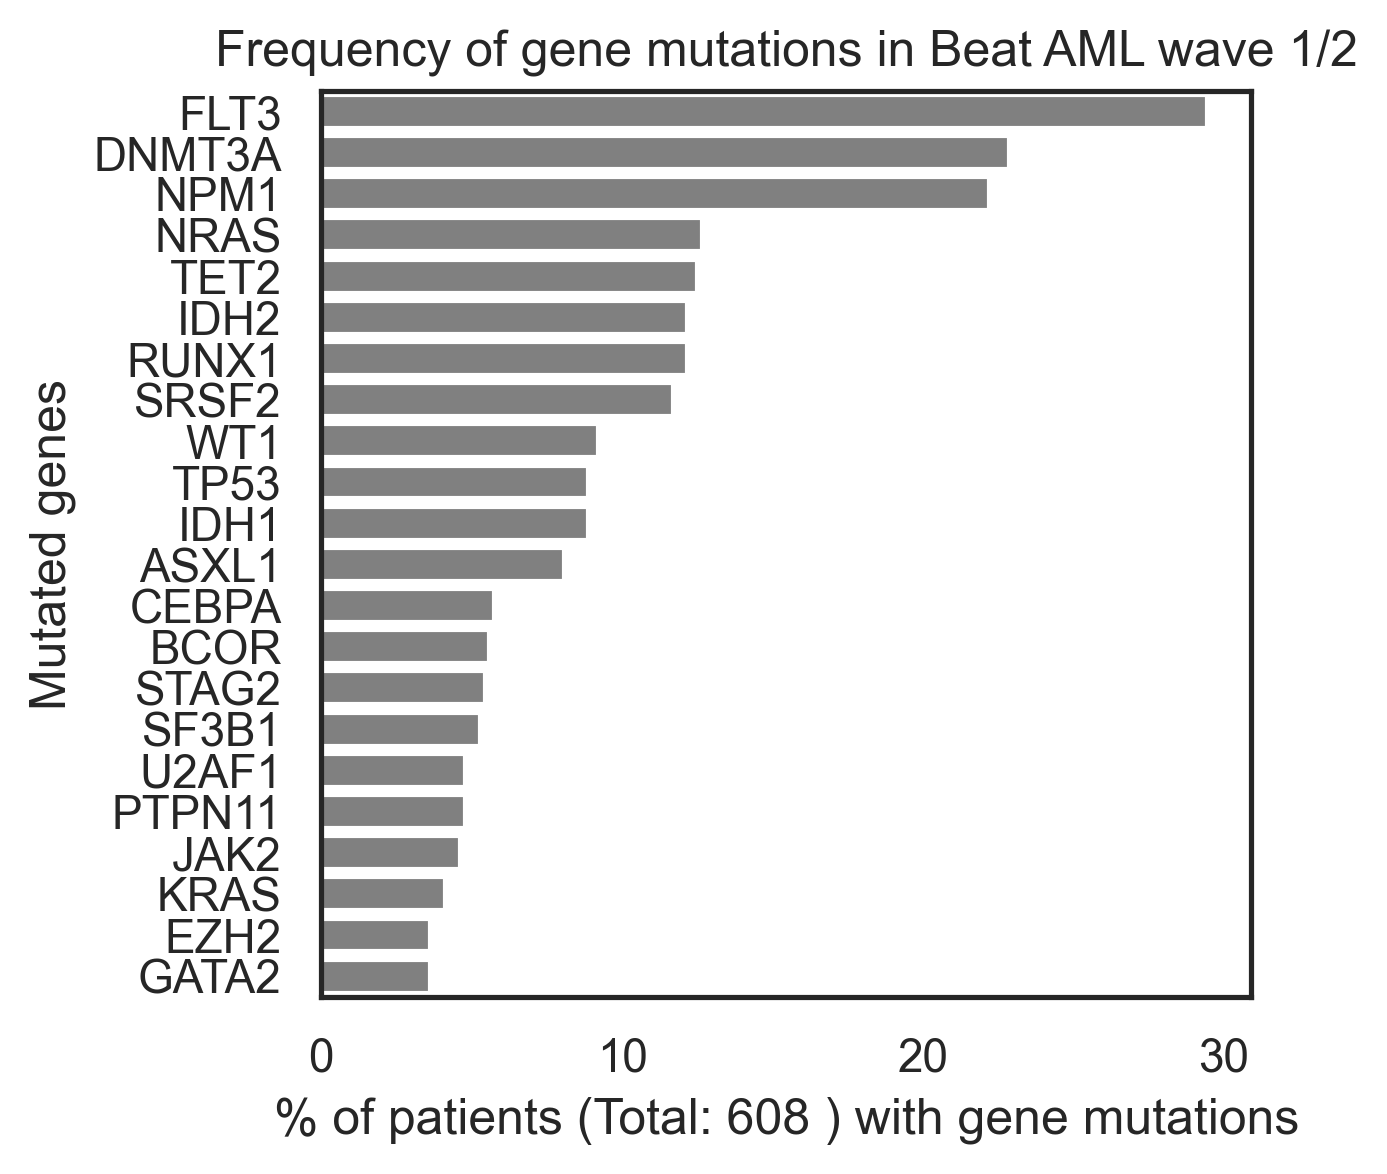

In [14]:
# Visualize the frequency of gene mutation
df_gene_mut_freq = selected_mutation_matrix.sum(axis = 0)/selected_mutation_matrix.shape[0] * 100
df_gene_mut_freq = df_gene_mut_freq.sort_values(ascending = False)
 
# convert the gene mutation frequency to a dataframe
df_gene_mut_freq = pd.DataFrame(df_gene_mut_freq, columns = ['Frequency'])
df_gene_mut_freq['Gene'] = df_gene_mut_freq.index

# bar plot for the frequency of gene mutation
import seaborn as sns
import matplotlib.pyplot as plt

# set background style
sns.set(style="white")
plt.figure(figsize=(4, 4), dpi=300)
sns.barplot(x = "Frequency", y = "Gene", 
            data = df_gene_mut_freq.sort_values(by = "Frequency", ascending = False),
            color="grey")
plt.xlabel("% of patients (Total: " + str(selected_mutation_matrix.shape[0])+ " ) with gene mutations")
plt.ylabel("Mutated genes")
plt.title("Frequency of gene mutations in Beat AML wave 1/2")
plt.show()


# Select variants or regions with high mutation frequency


In [17]:

BeatAML_mut['new_id'] = BeatAML_mut['symbol'] +':'+ BeatAML_mut['short_aa_change'] + ':' + BeatAML_mut['pos_start'].astype(str)
BeatAML_mut['new_id_patient'] = BeatAML_mut['labId'] + ':'+ BeatAML_mut['symbol'] +':'+ BeatAML_mut['short_aa_change']
BeatAML_mut.head(4)

,Unnamed: 0,chrom,pos_start,pos_end,ref,alt,labId,tumor_only,genotyper,total_reads,...,existing_variation,variant_class,sift,polyphen,exac_af,short_aa_change,validation,rna_status,new_id,new_id_patient
0,0,1,914477,914477,C,T,14-00141,0,mutect,33,...,NaN,SNV,tolerated(0.12),benign(0.002),NaN,p.A551T,not_covered,not_covered,C1orf170:p.A551T:914477,14-00141:C1orf170:p.A551T
1,1,1,914477,914477,C,T,14-00141,0,varscan,31,...,NaN,SNV,tolerated(0.12),benign(0.002),NaN,p.A551T,not_covered,not_covered,C1orf170:p.A551T:914477,14-00141:C1orf170:p.A551T
2,2,1,914941,914941,G,A,15-00492,0,mutect,74,...,NaN,SNV,tolerated(0.11),benign(0.003),NaN,p.A396V,not_done,not_done,C1orf170:p.A396V:914941,15-00492:C1orf170:p.A396V
3,3,1,914941,914941,G,A,15-00492,0,varscan,85,...,NaN,SNV,tolerated(0.11),benign(0.003),NaN,p.A396V,not_done,not_done,C1orf170:p.A396V:914941,15-00492:C1orf170:p.A396V


In [18]:
all_ids = set()
remain_index = set()

for i in range(0, BeatAML_mut.shape[0]):
    newid = BeatAML_mut.iloc[i,40]

    genotyper = BeatAML_mut.iloc[i,8]
    if genotyper == "mutect":
        if newid not in all_ids:
            remain_index.add(i)
        all_ids.add(newid)
print(len(remain_index))
for i in range(0, BeatAML_mut.shape[0]):
    newid = BeatAML_mut.iloc[i,40]

    genotyper = BeatAML_mut.iloc[i,8]
    if genotyper == "varscan":
        if newid in all_ids:
            all_ids.add(newid)
        else:
            remain_index.add(i)
            all_ids.add(newid)

print(len(remain_index))

BeatAML_mut_unique_vaf = BeatAML_mut.iloc[list(remain_index),]


4664
6305


In [19]:
# Select highly frequently mutated variants
BeatAML_mut_matrix_vaf = mc.convert_df2matrix_cont(BeatAML_mut_unique_vaf,'new_id','labId','t_vaf')
BeatAML_mut_matrix_vaf = BeatAML_mut_matrix_vaf.transpose()


In [20]:
BeatAML_mut_matrix_vaf

,SH3KBP1:p.G427S:19606780,CD37:p.S263*:49843527,TRIM33:p.Q438H:114969905,CEBPA:p.R297P:33792431,CCDC108:p.H1085L:219885879,NPM1:p.W288Cfs*12:170837545,MPPED2:p.V41L:30601800,RPS15A:p.K32R:18800341,WIPI1:p.V256I:66429643,WHSC1L1:p.Q293H:38194854,...,NBEAL2:p.H1266Q:47041387,CD3G:p.V142F:118221383,PUF60:p.S206R:144900231,DIAPH2:p.R1075Q:96684727,MPO:p.R302C:56355488,ZNF827:p.H839Q:146700530,TP53:p.V173M:7578413,TLN1:p.T1616I:35707177,MOCOS:p.S545L:33795777,EYS:p.D1070V:65531572
16-00135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14-00527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16-01017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16-00374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16-00050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13-00281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10-00792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13-00353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13-00098,NaN,NaN,NaN,NaN,NaN,0.252427,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Select highly frequent mutated variants
selected_variants = []
for gene in BeatAML_mut_matrix_vaf.columns:
    if BeatAML_mut_matrix_vaf.loc[BeatAML_mut_matrix_vaf[gene] > 0].shape[0] > 0.01*BeatAML_mut_matrix_vaf.shape[0]:
        selected_variants.append(gene)

BeatAML_mut_matrix_vaf_sele = BeatAML_mut_matrix_vaf[selected_variants]
BeatAML_mut_matrix_vaf_sele.columns

Index(['NPM1:p.W288Cfs*12:170837545', 'U2AF1:p.Q157P:44514777',
       'FLT3:p.I836del:28592634', 'IDH2:p.R140Q:90631934',
       'ASXL1:p.G646Wfs*12:31022441', 'SRSF2:p.P95_R102del:74732935',
       'IDH1:p.R132H:209113112', 'SF3B1:p.K666N:198267359',
       'NPM1:p.W288Cfs*12:170837544', 'FLT3:p.D835Y:28592642',
       'SF3B1:p.K700E:198266834', 'NRAS:p.Q61H:115256528',
       'IDH2:p.R172K:90631838', 'NPM1:p.W288Cfs*12:170837543',
       'SRSF2:p.P95H:74732959', 'FAM194A:p.V56E:150421519',
       'ASXL1:p.G645Vfs*58:31022441', 'U2AF1:p.S34F:44524456',
       'JAK2:p.V617F:5073770', 'SRSF2:p.P95R:74732959',
       'DNMT3A:p.R882C:25457243', 'NRAS:p.G13D:115258744',
       'IDH1:p.R132C:209113113', 'SRSF2:p.P95L:74732959',
       'NRAS:p.Q61K:115256530', 'FLT3:p.D835H:28592642',
       'NRAS:p.G12D:115258747', 'DNMT3A:p.R882H:25457242',
       'ZNF687:p.R939Pfs*36:151262327'],
      dtype='object')

In [22]:
selected_variants = {
    "ASXL1:p.G645-646":["ASXL1:p.G645Vfs*58:31022441",
                        'ASXL1:p.G646Wfs*12:31022441', 
                        'ASXL1:p.G645Wfs*12:31022441',],
    "FLT3:p.835-839":['FLT3:p.D835E:28592640',
                      'FLT3:p.D835H:28592642',
                      'FLT3:p.D835N:28592642',
                      'FLT3:p.D835V:28592641',
                      'FLT3:p.D835Y:28592642',
                      'FLT3:p.D839G:28592629',
                      'FLT3:p.I836del:28592634'],
                                          
     "IDH1:p.R132":['IDH1:p.R132C:209113113',
                        'IDH1:p.R132G:209113113',
                        'IDH1:p.R132H:209113112',
                        'IDH1:p.R132L:209113112',
                        'IDH1:p.R132S:209113113'],
    "IDH2:p.R140":['IDH2:p.R140L:90631934',
                    'IDH2:p.R140Q:90631934',
                    'IDH2:p.R140W:90631935'],

    "IDH2:p.R172":["IDH2:p.R172K:90631838"],

    "JAK2:p.V617":["JAK2:p.V617F:5073770"],
    "KIT:p.D816":[ 'KIT:p.D816H:55599320',
                    'KIT:p.D816V:55599321',
                    'KIT:p.D816Y:55599320'],
    "KRAS:p.G12/13":['KRAS:p.G12A:25398284',
                        'KRAS:p.G12C:25398285',
                        'KRAS:p.G12D:25398284',
                        'KRAS:p.G12R:25398285',
                        'KRAS:p.G12V:25398284',
                        'KRAS:p.G13D:25398281',
                        'KRAS:p.G13R:25398282'],
    "NF1:p.I679Dfs*21:29553477":["NF1:p.I679Dfs*21:29553477"],
    "NPM1:p.W288-90":['NPM1:p.W288Cfs*12:170837543',
                    'NPM1:p.W288Cfs*12:170837544',
                    'NPM1:p.W288Cfs*12:170837545',
                    'NPM1:p.W288Cfs*12:170837546',
                    'NPM1:p.W288Cfs*12:170837547',
                    'NPM1:p.W290Cfs*10:170837553',
                    'NPM1:p.W290Rfs*10:170837551'],
    "NRAS:p.G12/13":['NRAS:p.G12A:115258747',
                    'NRAS:p.G12C:115258748',
                    'NRAS:p.G12D:115258747',
                    'NRAS:p.G12R:115258748',
                    'NRAS:p.G12S:115258748',
                    'NRAS:p.G13C:115258745',
                    'NRAS:p.G13D:115258744',
                    'NRAS:p.G13R:115258745',
                    'NRAS:p.G13V:115258744',],
    "NRAS:p.Q61":['NRAS:p.Q61H:115256528',
                    'NRAS:p.Q61K:115256530',
                    'NRAS:p.Q61L:115256529',
                    'NRAS:p.Q61P:115256529',
                    'NRAS:p.Q61R:115256529'],
    "SF3B1:p.K700E":["SF3B1:p.K700E:198266834"],
    "SF3B1:p.K666":['SF3B1:p.K666E:198267361',
                    'SF3B1:p.K666M:198267360',
                    'SF3B1:p.K666N:198267359',
                    'SF3B1:p.K666Q:198267361',
                    'SF3B1:p.K666T:198267360'],
    "SRSF2:p.94-95":['SRSF2:p.P95H:74732959',
                        'SRSF2:p.P95L:74732959',
                        'SRSF2:p.P95R:74732959',
                        'SRSF2:p.P95_R102del:74732935',
                        'SRSF2:p.P95delinsRA:74732959',
                        'SRSF2:p.R94dup:74732959'],
    "U2AF1:p.S34":['U2AF1:p.S34F:44524456',
                    'U2AF1:p.S34Y:44524456'],
    "U2AF1:p.156-157":['U2AF1:p.Q157P:44514777',
                        'U2AF1:p.Q157R:44514777',
                        'U2AF1:p.R156H:44514780',],
    "ZNF687:p.R939Pfs*36:151262327":["ZNF687:p.R939Pfs*36:151262327"],
    }


In [36]:
BeatAML_mut_matrix_vaf.loc[:,list(set(selected_variants["NRAS:p.Q61"]).intersection(set(BeatAML_mut_matrix_vaf.columns)))].dropna()

,NRAS:p.Q61H:115256528,NRAS:p.Q61R:115256529,NRAS:p.Q61K:115256530,NRAS:p.Q61P:115256529


In [37]:
df_select_variants = pd.DataFrame()
for i in selected_variants:
    df_select_variants[i] = BeatAML_mut_matrix_vaf.loc[:,list(set(selected_variants[i]).intersection(set(BeatAML_mut_matrix_vaf.columns)))].sum(axis = 1)


In [41]:
print(df_select_variants.shape)
df_select_variants.sum(axis = 0)

(603, 18)


ASXL1:p.G645-646                  6.580722
FLT3:p.835-839                   11.355035
IDH1:p.R132                      20.942126
IDH2:p.R140                      22.519558
IDH2:p.R172                       4.976342
JAK2:p.V617                      10.386895
KIT:p.D816                        3.467462
KRAS:p.G12/13                     4.799768
NF1:p.I679Dfs*21:29553477         0.000000
NPM1:p.W288-90                   36.037696
NRAS:p.G12/13                    18.801233
NRAS:p.Q61                        8.130113
SF3B1:p.K700E                     3.693759
SF3B1:p.K666                      8.033271
SRSF2:p.94-95                    29.915678
U2AF1:p.S34                       5.539027
U2AF1:p.156-157                   4.675217
ZNF687:p.R939Pfs*36:151262327     1.752414
dtype: float64

In [46]:
df_select_variants.sum()

# remove the variants with zero frequency
df_select_variants1 = df_select_variants.loc[:,df_select_variants.sum(axis = 0) > 0]
df_select_variants1

,ASXL1:p.G645-646,FLT3:p.835-839,IDH1:p.R132,IDH2:p.R140,IDH2:p.R172,JAK2:p.V617,KIT:p.D816,KRAS:p.G12/13,NPM1:p.W288-90,NRAS:p.G12/13,NRAS:p.Q61,SF3B1:p.K700E,SF3B1:p.K666,SRSF2:p.94-95,U2AF1:p.S34,U2AF1:p.156-157,ZNF687:p.R939Pfs*36:151262327
16-00135,0.000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
14-00527,0.000,0.00000,0.352941,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.416309,0.000000,0.0,0.0,0.465517,0.0,0.0,0.0
16-01017,0.000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.548387,0.0,0.0,0.000000,0.0,0.0,0.0
16-00374,0.000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
16-00050,0.000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13-00281,0.125,0.00000,0.000000,0.442997,0.0,0.313131,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
10-00792,0.000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.369048,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
13-00353,0.000,0.31746,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
13-00098,0.000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.252427,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [47]:
df_select_variants.to_csv("../data/Feature_set2_variants_matrix_w12.csv")

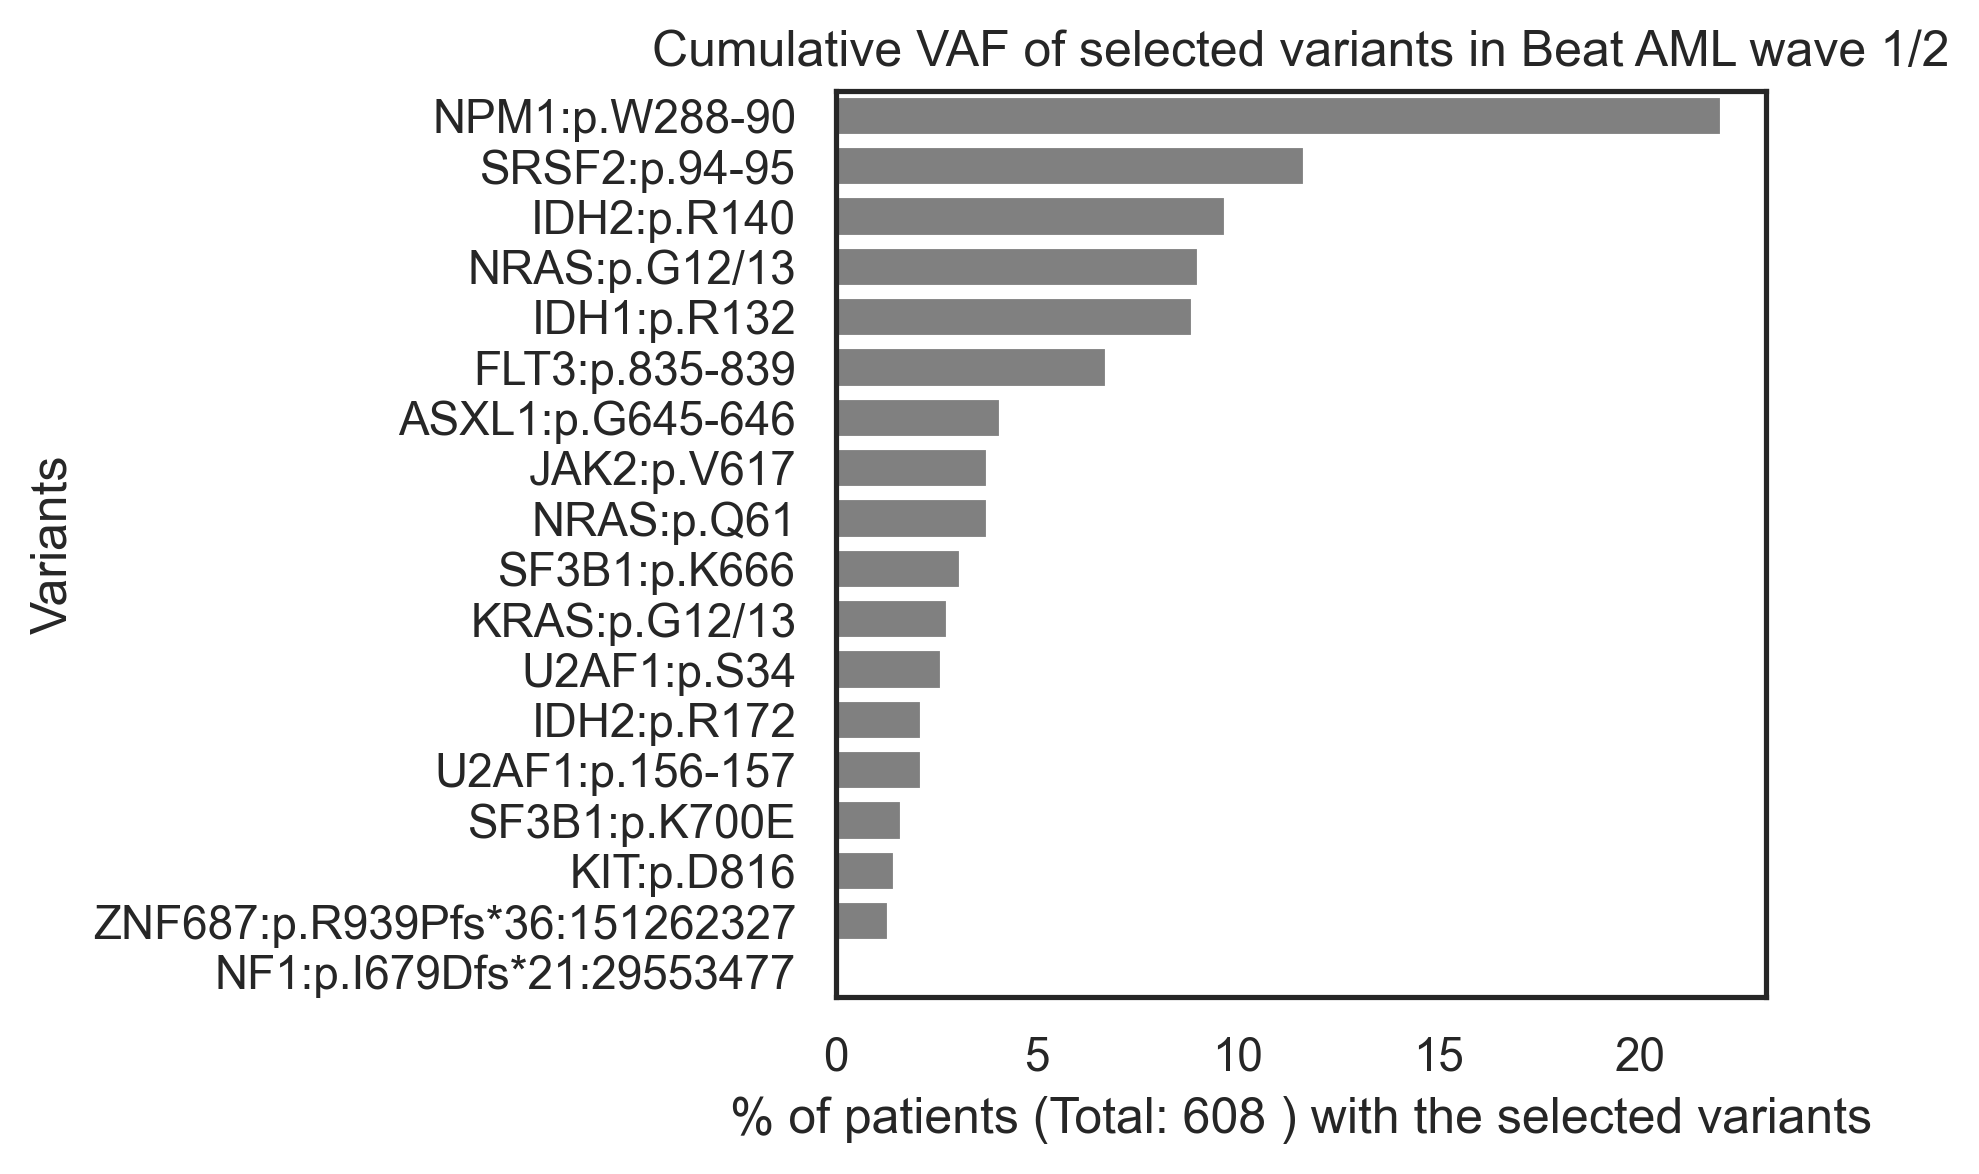

In [48]:
variants = pd.DataFrame()
Genes = []
variants = []
freq = []
for i in selected_variants:
    variants.append(i)
    Genes.append(i.split(":")[0])
    freq.append(df_select_variants.loc[df_select_variants[i] > 0].shape[0]/608*100)

variants = pd.DataFrame({"Gene":Genes,"variants":variants,"freq":freq})
variants

# barplot of the frequency of the selected variants ordered by the frequency
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4), dpi=300)
sns.barplot(x = "freq", y = "variants", 
            data = variants.sort_values(by = "freq", ascending = False),
            color="grey")
plt.xlabel("% of patients (Total: " +str(str(selected_mutation_matrix.shape[0])) + " ) with the selected variants")
plt.ylabel("Variants")
plt.title("Cumulative VAF of selected variants in Beat AML wave 1/2")
plt.show()

In [51]:
# outer join  df_select_variants and selected_mutation_matrix
print(df_select_variants1.shape)
print(selected_mutation_matrix.shape)
selected_merged_matrix = selected_mutation_matrix.join(df_select_variants1)
selected_merged_matrix = selected_merged_matrix.fillna(0)

#selected_merged_matrix = pd.concat([ selected_mutation_matrix, df_select_variants], axis = 1, join = "outer")
print(selected_merged_matrix.shape)


(603, 17)
(608, 22)
(608, 39)


In [52]:
selected_merged_matrix.to_csv("../data/Feature_set12_merged_matrix_w12.csv")

## RNASeq data processing


In [53]:
BeatAML_rnaseq

,Unnamed: 0,Gene,Symbol,12-00023,12-00051,12-00066,12-00150,12-00211,12-00258,12-00294,...,16-01216,16-01219,16-01223,16-01225,16-01227,16-01237,16-01254,16-01262,16-01270,16-01272
0,0,ENSG00000000003,TSPAN6,-1.562506,2.352541,-2.825696,1.688537,-3.272121,-3.561056,-3.287483,...,-0.382494,-1.896718,1.435855,-0.534799,0.509947,-0.830946,-2.923977,-0.998217,-0.964051,-1.042746
1,1,ENSG00000000419,DPM1,6.886609,6.438417,6.554495,6.852558,6.613863,7.045231,7.019496,...,7.203169,6.885383,7.166459,7.174516,6.500557,7.545959,6.882087,7.331555,6.254707,6.641892
2,2,ENSG00000000457,SCYL3,3.817626,3.987133,3.207921,3.878230,4.528385,3.762908,4.514343,...,3.611346,3.871390,3.992470,3.648833,4.503911,3.148649,4.077574,3.734620,3.811903,3.235035
3,3,ENSG00000000460,C1orf112,2.437114,1.862662,3.368360,3.332284,2.984168,2.964634,3.479539,...,2.245470,3.677613,2.523557,3.235564,3.197705,2.645294,3.115359,2.980670,2.670554,3.341608
4,4,ENSG00000000938,FGR,10.131911,5.014124,10.139119,5.941063,7.274613,10.538451,8.762846,...,9.715398,4.877051,6.218219,4.355385,5.746346,6.857559,10.782979,6.045946,6.383498,9.366073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22838,22838,ENSG00000273477,RP11-196O16.1,-0.219722,0.676291,0.518714,2.618279,1.581949,0.938443,-1.675077,...,-1.180687,2.245470,3.521457,1.726353,1.182989,2.261786,0.625404,1.414241,3.181330,0.353361
22839,22839,ENSG00000273483,RP4-671G15.2,-1.997200,-0.485151,-0.805189,-3.145493,-0.206438,0.016466,0.798736,...,-2.800714,0.493073,0.752237,1.389106,-1.656215,-1.706690,-1.028051,0.771490,-0.029557,-1.826434
22840,22840,ENSG00000273486,RP11-731C17.2,2.230568,1.029501,2.683986,1.676374,2.879371,2.305506,3.563519,...,4.285504,4.583648,3.716998,3.213924,4.411679,4.070881,2.267735,3.317902,3.403906,1.501366
22841,22841,ENSG00000273487,RP4-621B10.8,-0.633602,-1.905383,-2.185010,-3.561056,0.847544,1.297656,1.458084,...,-3.064365,-1.694540,-0.062792,0.468829,-1.758246,-1.802393,1.330709,0.942407,-2.446318,-2.597849


In [54]:
BeatAML_rnaseq["RNAseq_geneSymbol"] = BeatAML_rnaseq['Gene']

In [57]:
BeatAML_rnaseq.head(3)

,Unnamed: 0,Gene,Symbol,12-00023,12-00051,12-00066,12-00150,12-00211,12-00258,12-00294,...,16-01219,16-01223,16-01225,16-01227,16-01237,16-01254,16-01262,16-01270,16-01272,RNAseq_geneSymbol
0,0,ENSG00000000003,TSPAN6,-1.562506,2.352541,-2.825696,1.688537,-3.272121,-3.561056,-3.287483,...,-1.896718,1.435855,-0.534799,0.509947,-0.830946,-2.923977,-0.998217,-0.964051,-1.042746,ENSG00000000003
1,1,ENSG00000000419,DPM1,6.886609,6.438417,6.554495,6.852558,6.613863,7.045231,7.019496,...,6.885383,7.166459,7.174516,6.500557,7.545959,6.882087,7.331555,6.254707,6.641892,ENSG00000000419
2,2,ENSG00000000457,SCYL3,3.817626,3.987133,3.207921,3.878230,4.528385,3.762908,4.514343,...,3.871390,3.992470,3.648833,4.503911,3.148649,4.077574,3.734620,3.811903,3.235035,ENSG00000000457


In [59]:
BeatAML_rnaseq_matrix = BeatAML_rnaseq.iloc[0:,3:-1]
BeatAML_rnaseq_matrix.index = list(BeatAML_rnaseq.iloc[0:,-1])

print(BeatAML_rnaseq_matrix.shape)

(22843, 451)


In [60]:
remain_indexs = []
for index in range(0,BeatAML_rnaseq_matrix.shape[0] ):
    cur_values = BeatAML_rnaseq_matrix.iloc[index,:].values
    if len(cur_values[cur_values>0]) >= BeatAML_rnaseq_matrix.shape[1]/2:
        remain_indexs.append(index)

In [61]:
print(len(remain_indexs))

BeatAML_rnaseq_matrix.head(5)

17691


,12-00023,12-00051,12-00066,12-00150,12-00211,12-00258,12-00294,12-00372,12-00423,12-00426,...,16-01216,16-01219,16-01223,16-01225,16-01227,16-01237,16-01254,16-01262,16-01270,16-01272
ENSG00000000003,-1.562506,2.352541,-2.825696,1.688537,-3.272121,-3.561056,-3.287483,-0.149916,-1.232077,-1.778046,...,-0.382494,-1.896718,1.435855,-0.534799,0.509947,-0.830946,-2.923977,-0.998217,-0.964051,-1.042746
ENSG00000000419,6.886609,6.438417,6.554495,6.852558,6.613863,7.045231,7.019496,6.698076,6.565889,6.553925,...,7.203169,6.885383,7.166459,7.174516,6.500557,7.545959,6.882087,7.331555,6.254707,6.641892
ENSG00000000457,3.817626,3.987133,3.207921,3.878230,4.528385,3.762908,4.514343,4.226222,3.606704,4.574380,...,3.611346,3.871390,3.992470,3.648833,4.503911,3.148649,4.077574,3.734620,3.811903,3.235035
ENSG00000000460,2.437114,1.862662,3.368360,3.332284,2.984168,2.964634,3.479539,2.549459,3.011702,2.502817,...,2.245470,3.677613,2.523557,3.235564,3.197705,2.645294,3.115359,2.980670,2.670554,3.341608
ENSG00000000938,10.131911,5.014124,10.139119,5.941063,7.274613,10.538451,8.762846,8.009340,8.170395,6.420402,...,9.715398,4.877051,6.218219,4.355385,5.746346,6.857559,10.782979,6.045946,6.383498,9.366073


In [62]:
BeatAML_rnaseq_matrix.iloc[remain_indexs,:].transpose().to_csv("../data/Feature_set3_RNAseq_matrix_w12.csv")

In [70]:
feature_matrix = pd.concat([selected_merged_matrix, BeatAML_rnaseq_matrix.iloc[remain_indexs,:].transpose()], axis = 1, join = "outer")
#feature_matrix_noNA = feature_matrix.dropna()


In [64]:
feature_matrix.to_csv("../Data/Feature_set123_merged_matrix_w12.csv")

In [65]:
# Ready to use features

## 1. Feature set 1:
print(selected_mutation_matrix.shape)

## 2. Feature set 2:
print(df_select_variants1.shape)

## 3. Feature set 1 and 2: 
print(selected_merged_matrix.shape)

## 4. Feature set 1, 2, and 3
print(feature_matrix.shape)

#selected_mutation_matrix.to_csv("../Data/Feature_set1_mutation_matrix_w12.csv")
#df_select_variants.to_csv("../Data/Feature_set2_variants_matrix_w12.csv")
#selected_merged_matrix.to_csv( "../Data/Feature_set12_merged_matrix_w12.csv")
#feature_matrix.to_csv("../Data/Feature_set123_merged_matrix_w12.csv")


(608, 22)
(603, 17)
(608, 39)
(660, 17730)


# Generate feature and label matrix for IC50

In [66]:
#BeatAML_drug_response_ic50_matrix = convert_df2matrix_cont(BeatAML_drug_response, 'lab_id', 'inhibitor', 'ic50') 
BeatAML_drug_response_ic50_matrix = mc.convert_df2matrix_cont(BeatAML_drug_response, 'lab_id', 'inhibitor', 'ic50') 
beatAML_data_feature_ic50 = pd.concat([feature_matrix,BeatAML_drug_response_ic50_matrix], axis = 1, join = "outer")


In [68]:
beatAML_data_feature_ic50.to_csv("../data/beatAML_wave12_feature_ic50_highExpr_Apr30_2024_w12.csv")

# Generate feature and label matrix for AUC

In [69]:
BeatAML_drug_response_auc_matrix = mc.convert_df2matrix_cont(BeatAML_drug_response, 'lab_id', 'inhibitor', 'auc') 
beatAML_data_feature_auc = pd.concat([feature_matrix,BeatAML_drug_response_auc_matrix], axis = 1, join = "outer")
beatAML_data_feature_auc.to_csv("../Data/beatAML_wave12_feature_auc_highExpr_Apr30_2024_w12.csv")